In [1]:
import time
start_simulation = time.time()

import os

import numpy             as np
import matplotlib.pyplot as plt
import scipy.sparse      as sparse
import scipy.special     as sp

import hylife.utilitis_FEEC.bsplines             as bsp
import hylife.utilitis_FEEC.projectors_local_mhd as mhd
import hylife.utilitis_FEEC.projectors_local     as proj
import hylife.utilitis_FEEC.derivatives          as der
import hylife.utilitis_FEEC.evaluation           as eva
import hylife.utilitis_FEEC.mass_matrices        as mass
import hylife.utilitis_FEEC.control_variate      as cv

import hylife.utilitis_PIC_April2020.STRUPHY_fields        as pic_fields
import hylife.utilitis_PIC_April2020.STRUPHY_pusher        as pic_pusher
import hylife.utilitis_PIC_April2020.STRUPHY_accumulation  as pic_accumu
import hylife.utilitis_PIC_April2020.STRUPHY_sampling      as pic_sample
import hylife.utilitis_PIC_April2020.sobol_seq             as sobol

import hylife.geometry.mappings_analytical as mapping    
import hylife.interface as inter

In [2]:
# ======================== load parameters ============================
import simulation_06042020_2.parameters as pa    # name input folder here!
identifier = 'simulation_06042020_2'             # name input folder here!

params = pa.parameters()

Nel          = params.Nel            # mesh generation on logical domain
bc           = params.bc             # boundary conditions (True: periodic, False: else)
p            = params.p              # spline degrees  


time_int     = params.time_int       # do time integration ?
dt           = params.dt             # time step
Tend         = params.Tend           # simulation time
max_time     = params.max_time       # maximum runtime of program in minutes
add_pressure = params.add_pressure   # add non-Hamiltonian terms to simulation?

# geometry
kind_map     = params.kind_map       # 1 : slab, 2 : hollow cylinder, 3 : colella
params_map   = params.params_map     # parameters for mapping  

# physical constants
gamma        = params.gamma          # adiabatic exponent

# particle parameters
add_PIC      = params.add_PIC        # add kinetic terms to simulation?
Np           = params.Np             # total number of particles
control      = params.control        # control variate on/off

v0x          = params.v0x            # shift of Maxwellian in vx - direction
v0y          = params.v0y            # shift of Maxwellian in vx - direction
v0z          = params.v0z            # shift of Maxwellian in vz - direction

vth          = params.vth            # thermal velocity of Maxwellian


loading      = params.loading



# restart function
restart        = params.restart  

name_particles = identifier + '/restart_files/' + 'restart=particles1.npy'
name_rho_coeff = identifier + '/restart_files/' + 'restart=rho_coeff1.npy'
name_u1_coeff  = identifier + '/restart_files/' + 'restart=u1_coeff1.npy'
name_u2_coeff  = identifier + '/restart_files/' + 'restart=u2_coeff1.npy'
name_u3_coeff  = identifier + '/restart_files/' + 'restart=u3_coeff1.npy'
name_b1_coeff  = identifier + '/restart_files/' + 'restart=b1_coeff1.npy'
name_b2_coeff  = identifier + '/restart_files/' + 'restart=b2_coeff1.npy'
name_b3_coeff  = identifier + '/restart_files/' + 'restart=b3_coeff1.npy'
name_p_coeff   = identifier + '/restart_files/' + 'restart=p_coeff1.npy'
name_control   = identifier + '/restart_files/' + 'restart=CV1.npy'
name_time_step = identifier + '/restart_files/' + 'restart=time1.npy'


create_restart = params.create_restart
dir_restart    = identifier + '/restart_files/'
# ========================================================================

In [8]:
# ================== basics ==============================================
el_b        = [np.linspace(0., 1., Nel + 1) for Nel in Nel]                      # element boundaries
delta       = [1/Nel for Nel in Nel]                                             # element sizes
T           = [bsp.make_knots(el_b, p, bc) for el_b, p, bc in zip(el_b, p, bc)]  # knot vectors (for N functions)
t           = [T[1:-1] for T in T]                                               # reduced knot vectors (for D function)
NbaseN      = [Nel + p - bc*p for Nel, p, bc in zip(Nel, p, bc)]                 # number of basis functions (N functions)
NbaseD      = [NbaseN - (1 - bc) for NbaseN, bc in zip(NbaseN, bc)]              # number of basis functions (D functions)
Ntot        =  NbaseN[0]*NbaseN[1]*NbaseN[2]                                     # total number of basis functions in V0

Nbase_0form =  [NbaseN[0], NbaseN[1], NbaseN[2]]
Nbase_1form = [[NbaseD[0], NbaseN[1], NbaseN[2]], [NbaseN[0], NbaseD[1], NbaseN[2]], [NbaseN[0], NbaseN[1], NbaseD[2]]]
Nbase_2form = [[NbaseN[0], NbaseD[1], NbaseD[2]], [NbaseD[0], NbaseN[1], NbaseD[2]], [NbaseD[0], NbaseD[1], NbaseN[2]]]
Nbase_3form =  [NbaseD[0], NbaseD[1], NbaseD[2]]

Ntot_0form  =  NbaseN[0]*NbaseN[1]*NbaseN[2] 
Ntot_1form  = [NbaseD[0]*NbaseN[1]*NbaseN[2], NbaseN[0]*NbaseD[1]*NbaseN[2], NbaseN[0]*NbaseN[1]*NbaseD[2]]
Ntot_2form  = [NbaseN[0]*NbaseN[1]*NbaseD[2], NbaseD[0]*NbaseN[1]*NbaseD[2], NbaseD[0]*NbaseD[1]*NbaseN[2]]  
Ntot_3form  =  NbaseD[0]*NbaseD[1]*NbaseD[2] 


if add_PIC == True:
    # delta-f corrections
    if control == True:
        cont = cv.terms_control_variate(T, p, bc, kind_map, params_map)

    # particle accumulator
    acc = pic_accumu.accumulation(T, p, bc)
# =======================================================================


# ===== coefficients for pp-forms in interval [0, delta] (N and D) ======
pp0 = []
pp1 = []

for i in range(3):
    if p[i] == 3:
        pp0.append(np.asfortranarray([[1/6, -1/(2*delta[i]), 1/(2*delta[i]**2), -1/(6*delta[i]**3)], [2/3, 0., -1/delta[i]**2, 1/(2*delta[i]**3)], [1/6, 1/(2*delta[i]), 1/(2*delta[i]**2), -1/(2*delta[i]**3)], [0., 0., 0., 1/(6*delta[i]**3)]]))
        pp1.append(np.asfortranarray([[1/2, -1/delta[i], 1/(2*delta[i]**2)], [1/2, 1/delta[i], -1/delta[i]**2], [0., 0., 1/(2*delta[i]**2)]])/delta[i])
    elif p[i] == 2:
        pp0.append(np.asfortranarray([[1/2, -1/delta[i], 1/(2*delta[i]**2)], [1/2, 1/delta[i], -1/delta[i]**2], [0., 0., 1/(2*delta[i]**2)]]))
        pp1.append(np.asfortranarray([[1., -1/delta[i]], [0., 1/delta[i]]])/delta[i])
    else:
        print('So far only cubic and quadratic splines implemented!')
# ======================================================================

In [9]:
# ========= reserve memory for FEM cofficients and particles ===========
pr     = np.empty(Nbase_0form,    dtype=float, order='F')     # pressure FEM coefficients

u1     = np.empty(Nbase_1form[0], dtype=float, order='F')
u2     = np.empty(Nbase_1form[1], dtype=float, order='F')
u3     = np.empty(Nbase_1form[2], dtype=float, order='F')

u1_old = np.empty(Nbase_1form[0], dtype=float, order='F')
u2_old = np.empty(Nbase_1form[1], dtype=float, order='F')
u3_old = np.empty(Nbase_1form[2], dtype=float, order='F')

b1     = np.empty(Nbase_2form[0], dtype=float, order='F')
b2     = np.empty(Nbase_2form[1], dtype=float, order='F')
b3     = np.empty(Nbase_2form[2], dtype=float, order='F')

rho    = np.empty(Nbase_3form,    dtype=float, order='F')     # density FEM coefficients


# particles
particles = np.empty((Np, 7), dtype=float, order='F')
w0        = np.empty(Np, dtype=float)
g0        = np.empty(Np, dtype=float)

# fields at particle positions
B_part = np.empty((Np, 3), dtype=float, order='F')
U_part = np.empty((Np, 3), dtype=float, order='F')

# energies (bulk kinetic energy, magnetic energy, bulk internal energy, hot ion kinetic + internal energy (delta f))
energies = np.empty(4, dtype=float)
# =========================================================================

In [11]:
# ============= projection of initial conditions ==========================
# create object for projecting initial conditions
pro = proj.projectors_local_3d(T, p, bc)

# projection of initial conditions
if params.ic_from_params == True:
    pr[:, :, :]                           = pro.PI_0(lambda xi1, xi2, xi3 : params.p_ini(xi1, xi2, xi3))
    u1[:, :, :], u2[:, :, :], u3[:, :, :] = pro.PI_1([lambda xi1, xi2, xi3 : params.u1_ini(xi1, xi2, xi3), lambda xi1, xi2, xi3 : params.u2_ini(xi1, xi2, xi3), lambda xi1, xi2, xi3 : params.u3_ini(xi1, xi2, xi3)]) 
    b1[:, :, :], b2[:, :, :], b3[:, :, :] = pro.PI_2([lambda xi1, xi2, xi3 : params.b1_ini(xi1, xi2, xi3), lambda xi1, xi2, xi3 : params.b2_ini(xi1, xi2, xi3), lambda xi1, xi2, xi3 : params.b3_ini(xi1, xi2, xi3)])
    rho[:, :, :]                          = pro.PI_3(lambda xi1, xi2, xi3 : params.p_ini(xi1, xi2, xi3))
    
else:
    pr[:, :, :]                           = pro.PI_0( None,               1,        kind_map, params_map)
    u1[:, :, :], u2[:, :, :], u3[:, :, :] = pro.PI_1([None, None, None], [2, 3, 4], kind_map, params_map) 
    b1[:, :, :], b2[:, :, :], b3[:, :, :] = pro.PI_2([None, None, None], [5, 6, 7], kind_map, params_map)
    rho[:, :, :]                          = pro.PI_3( None,               8,        kind_map, params_map)

del pro

print('projection of initial conditions done!')
# ==========================================================================

projection of initial conditions done!


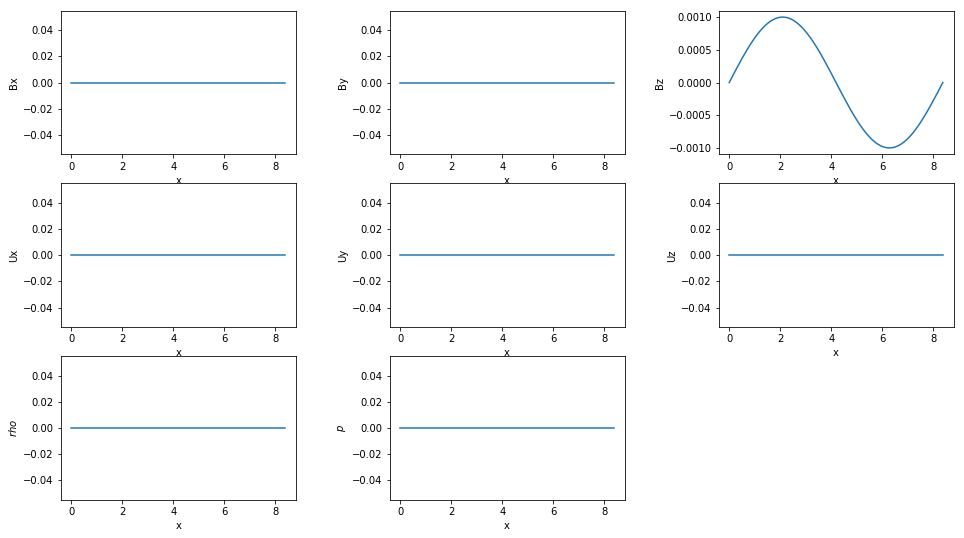

In [14]:
# plot initial conditions on physical domain
xiplot = np.linspace(0., 1., 200), np.array([0.5]), np.array([0.5])


pini                = eva.FEM_field_V0_3d(pr, xiplot, T, p, bc)
Uini1, Uini2, Uini3 = eva.FEM_field_V1_3d([u1, u2, u3], xiplot, T, p, bc)
Bini1, Bini2, Bini3 = eva.FEM_field_V2_3d([b1, b2, b3], xiplot, T, p, bc)
rhoini              = eva.FEM_field_V3_3d(rho, xiplot, T, p, bc)


g_sqrt = mapping.det_df(0., 0., 0., kind_map, params_map)
DF     = np.empty((3, 3), dtype=float)
DFinv  = np.empty((3, 3), dtype=float)
component = [[11, 12, 13], [21, 22, 23], [31, 32, 33]]

for i in range(3):
    for j in range(3):
        DF[i, j]    = mapping.df(0., 0., 0., kind_map, params_map, component[i][j])
        DFinv[i, j] = mapping.df_inv(0., 0., 0., kind_map, params_map, component[i][j])


fig = plt.figure()
fig.set_figwidth(16)
fig.set_figheight(9)

plt.subplot(3, 3, 1)
plt.plot(xiplot[0]*params_map[0], 1/g_sqrt*DF[0, 0]*Bini1[:, 0, 0])
plt.xlabel('x')
plt.ylabel('Bx')

plt.subplot(3, 3, 2)
plt.plot(xiplot[0]*params_map[0], 1/g_sqrt*DF[1, 1]*Bini2[:, 0, 0])
plt.xlabel('x')
plt.ylabel('By')

plt.subplot(3, 3, 3)
plt.plot(xiplot[0]*params_map[0], 1/g_sqrt*DF[2, 2]*Bini3[:, 0, 0])
plt.xlabel('x')
plt.ylabel('Bz')

plt.subplot(3, 3, 4)
plt.plot(xiplot[0]*params_map[0], DFinv[0, 0]*Uini1[:, 0, 0])
plt.xlabel('x')
plt.ylabel('Ux')

plt.subplot(3, 3, 5)
plt.plot(xiplot[0]*params_map[0], DFinv[1, 1]*Uini2[:, 0, 0])
plt.xlabel('x')
plt.ylabel('Uy')

plt.subplot(3, 3, 6)
plt.plot(xiplot[0]*params_map[0], DFinv[2, 2]*Uini3[:, 0, 0])
plt.xlabel('x')
plt.ylabel('Uz')

plt.subplot(3, 3, 7)
plt.plot(xiplot[0]*params_map[0], rhoini[:, 0, 0]/g_sqrt)
plt.xlabel('x')
plt.ylabel('$rho$')

plt.subplot(3, 3, 8)
plt.plot(xiplot[0]*params_map[0], pini[:, 0, 0])
plt.xlabel('x')
plt.ylabel('$p$')

plt.subplots_adjust(wspace=0.4)

In [15]:
# ============================================ MHD matrices ===========================================================
# create object for projecting MHD matrices
MHD = mhd.projectors_local_mhd(T, p, bc)

# mass matrices in V0, V1 and V2
M0 = mass.mass_V0_3d(T, p, bc,  None,        kind_map, params_map)
M1 = mass.mass_V1_3d(T, p, bc, [None, None], kind_map, params_map)
M2 = mass.mass_V2_3d(T, p, bc, [None, None], kind_map, params_map)

print('mass matrices done')

# normalization vector in V0
norm = mass.inner_prod_V0_3d(T, p, bc, lambda xi1, xi2, xi3 : np.ones(xi1.shape), None, kind_map, params_map).flatten()

# discrete grad, curl and div matrices
derivatives = der.discrete_derivatives(T, p, bc)

GRAD = derivatives.GRAD_3d()
CURL = derivatives.CURL_3d()
DIV  = derivatives.DIV_3d()

# projection matrices
Q   = MHD.projection_Q(kind_map, params_map)
W   = MHD.projection_W(kind_map, params_map)
TAU = MHD.projection_T(kind_map, params_map)
S   = MHD.projection_S(kind_map, params_map)
K   = MHD.projection_K(kind_map, params_map).tocsc()

print('projection matrices done')

# compute matrix A
A = 1/2*(M1.dot(W) + W.T.dot(M1)).tocsc()

del W

# LU decompostion of Schur complement in step 2
STEP2_schur_LU = sparse.linalg.splu((A + dt**2/4*TAU.T.dot(CURL.T.dot(M2.dot(CURL.dot(TAU))))).tocsc())

# other matrices needed in step 2
STEP2_1 = (A - dt**2/4*TAU.T.dot(CURL.T.dot(M2.dot(CURL.dot(TAU))))).tocsc()
STEP2_2 = dt*TAU.T.dot(CURL.T.dot(M2)).tocsc()

# matrices for non-Hamiltonian part
MAT = GRAD.T.dot(M1).dot(S) + (gamma - 1)*K.T.dot(GRAD.T).dot(M1)

del S, K

LHS_LU = sparse.linalg.splu((sparse.bmat([[sparse.identity(Ntot),  dt/2*DIV.dot(Q), None], [None, A,  dt/2*M1.dot(GRAD)], [None, -dt/2*MAT, M0]])).tocsc())
RHS    =                     sparse.bmat([[sparse.identity(Ntot), -dt/2*DIV.dot(Q), None], [None, A, -dt/2*M1.dot(GRAD)], [None,  dt/2*MAT, M0]], format='csc')

# delete everything which is not needed to save memory
del MHD, M0, GRAD, DIV, Q, MAT

print('assembly of constant matrices done!')
# ======================================================================================================================

mass matrices done
projection matrices done
assembly of constant matrices done!


In [16]:
# check initial control variates
J14_control = cont.inner_prod_V1_jh_eq(b1, b2, b3, kind_map, params_map)
J14_coeff1, J14_coeff2, J14_coeff3 = np.split(sparse.linalg.spsolve(M1, np.concatenate((J14_control[0].flatten(), J14_control[1].flatten(), J14_control[2].flatten()))), [Ntot_1form[0], Ntot_1form[0] + Ntot_1form[1]])
J141, J142, J143 = eva.FEM_field_V1_3d([J14_coeff1, J14_coeff2, J14_coeff3], xiplot, T, p, bc)

J11_control = cont.mass_V1_nh_eq(b1, b2, b3, kind_map, params_map)
J11_coeff1, J11_coeff2, J11_coeff3 = np.split(sparse.linalg.spsolve(M1, -J11_control.dot(np.concatenate((u1.flatten(), u2.flatten(), u3.flatten())))), [Ntot_1form[0], Ntot_1form[0] + Ntot_1form[1]]) 
J111, J112, J113 = eva.FEM_field_V1_3d([J11_coeff1, J11_coeff2, J11_coeff3], xiplot, T, p, bc)


fig = plt.figure()
fig.set_figwidth(16)
fig.set_figheight(6)

plt.subplot(2, 3, 1)
plt.plot(xiplot[0]*params_map[0], DFinv[0, 0]*J141[:, 0, 0])
plt.xlabel('z')
plt.ylabel('$(B x j_{h0})_x$')

plt.subplot(2, 3, 2)
plt.plot(xiplot[0]*params_map[0], DFinv[1, 1]*J142[:, 0, 0])
plt.xlabel('z')
plt.ylabel('$(Bx j_{h0})_y$')

plt.subplot(2, 3, 3)
plt.plot(xiplot[0]*params_map[0], DFinv[2, 2]*J143[:, 0, 0])
plt.xlabel('z')
plt.ylabel('$(Bx j_{h0})_z$')

plt.subplot(2, 3, 4)
plt.plot(xiplot[0]*params_map[0], DFinv[0, 0]*J111[:, 0, 0])
plt.xlabel('z')
plt.ylabel('$n_{h0}(U x B)_x$')

plt.subplot(2, 3, 5)
plt.plot(xiplot[0]*params_map[0], DFinv[1, 1]*J112[:, 0, 0])
plt.xlabel('z')
plt.ylabel('$n_{h0}(U x B)_y$')

plt.subplot(2, 3, 6)
plt.plot(xiplot[0]*params_map[0], DFinv[2, 2]*J113[:, 0, 0])
plt.xlabel('z')
plt.ylabel('$n_{h0}(U x B)_z$')

plt.subplots_adjust(wspace=0.4)

NameError: name 'cont' is not defined

In [17]:
# ================================================ create particles ====================================================
if   loading == 'pseudo-random':
    # pseudo-random numbers between (0, 1)
    particles[:, :6] = np.random.rand(Np, 6)
    
elif loading == 'sobol_standard':
    # plain sobol numbers between (0, 1) (skip first 1000 numbers)
    particles[:, :6] = sobol.i4_sobol_generate(6, Np, 1000) 
    
elif loading == 'sobol_antithetic':
    # symmetric sobol numbers between (0, 1) (skip first 1000 numbers) in all 6 dimensions
    pic_sample.set_particles_symmetric(sobol.i4_sobol_generate(6, int(Np/64), 1000), particles)  
    
elif loading == 'pr_space_uni_velocity':
    # pseudo-random numbers in space and uniform in velocity space
    particles[:, :3] = np.random.rand(Np, 3)
    
    dv = 1/Np
    particles[:,  3] = np.linspace(dv, 1 - dv, Np)
    particles[:,  4] = np.linspace(dv, 1 - dv, Np)
    particles[:,  5] = np.linspace(dv, 1 - dv, Np)
    
elif loading == 'external':
    # load numbers between (0, 1) from an external file
    particles[:, :6] = np.load('test_particles.npy')
    
else:
    print('particle loading not specified')

# inversion of cumulative distribution function
particles[:, 3]  = sp.erfinv(2*particles[:, 3] - 1)*vth + v0x
particles[:, 4]  = sp.erfinv(2*particles[:, 4] - 1)*vth + v0y
particles[:, 5]  = sp.erfinv(2*particles[:, 5] - 1)*vth + v0z

# compute initial weights
pic_sample.compute_weights_ini(particles, w0, g0, kind_map, params_map)

if control == True:
    pic_sample.update_weights(particles, w0, g0, kind_map, params_map)
else:
    particles[:, 6] = w0

print('particle initialization done!')
# =====================================================================================================================

particle initialization done!


In [18]:
# ================ compute initial fields at particle positions and initial energies ==================================
if add_PIC == True:
    timea = time.time()
    pic_fields.evaluate_2form(particles[:, 0:3], T[0], T[1], T[2], t[0], t[1], t[2], p, Nel, np.asfortranarray(Nbase_2form), Np, b1, b2, b3, pp0[0], pp0[1], pp0[2], pp1[0], pp1[1], pp1[2], B_part, kind_map, params_map)
    pic_fields.evaluate_1form(particles[:, 0:3], T[0], T[1], T[2], t[0], t[1], t[2], p, Nel, np.asfortranarray(Nbase_1form), Np, u1, u2, u3, pp0[0], pp0[1], pp0[2], pp1[0], pp1[1], pp1[2], U_part, kind_map, params_map)
    timeb = time.time()
    print('initial field computation at particles done. Time : ', timeb-timea)


# initial energies
energies[0] = 1/2*np.concatenate((u1.flatten(), u2.flatten(), u3.flatten())).dot(A.dot(np.concatenate((u1.flatten(), u2.flatten(), u3.flatten()))))
energies[1] = 1/2*np.concatenate((b1.flatten(), b2.flatten(), b3.flatten())).dot(M2.dot(np.concatenate((b1.flatten(), b2.flatten(), b3.flatten()))))
energies[2] = 1/(gamma - 1)*pr.flatten().dot(norm)
energies[3] = 1/2*particles[:, 6].dot(particles[:, 3]**2 + particles[:, 4]**2 + particles[:, 5]**2)/Np + (control - 1)*inter.eh_eq(kind_map, params_map)
# =====================================================================================================================

initial field computation at particles done. Time :  3.0473287105560303


Text(0,0.5,'$n_{h0}(U x B)_z$')

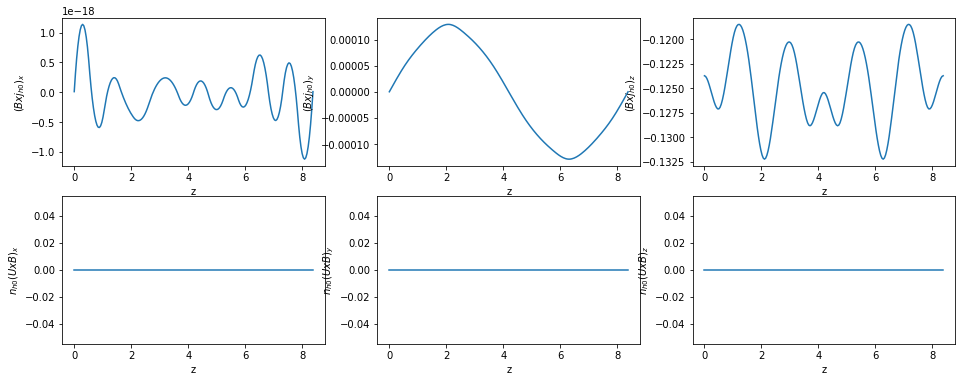

In [20]:
# check initial accumulation terms
J14 = acc.accumulation_step3(particles, B_part, kind_map, params_map)[1]
J14_coeff1, J14_coeff2, J14_coeff3 = np.split(sparse.linalg.spsolve(M1,  J14/Np), [Ntot_1form[0], Ntot_1form[0] + Ntot_1form[1]])
J141, J142, J143 = eva.FEM_field_V1_3d([J14_coeff1, J14_coeff2, J14_coeff3], xiplot, T, p, bc)


J11 = acc.accumulation_step1(particles, B_part, kind_map, params_map)
J11_coeff1, J11_coeff2, J11_coeff3 = np.split(sparse.linalg.spsolve(M1, -J11.dot(np.concatenate((u1.flatten(), u2.flatten(), u3.flatten())))), [Ntot_1form[0], Ntot_1form[0] + Ntot_1form[1]]) 
J111, J112, J113 = eva.FEM_field_V1_3d([J11_coeff1, J11_coeff2, J11_coeff3], xiplot, T, p, bc)

fig = plt.figure()
fig.set_figwidth(16)
fig.set_figheight(6)


plt.subplot(2, 3, 1)
plt.plot(xiplot[0]*params_map[0], DFinv[0, 0]*J141[:, 0, 0])
plt.xlabel('z')
plt.ylabel('$(Bx j_{h0})_x$')

plt.subplot(2, 3, 2)
plt.plot(xiplot[0]*params_map[0], DFinv[1, 1]*J142[:, 0, 0])
plt.xlabel('z')
plt.ylabel('$(Bx j_{h0})_y$')

plt.subplot(2, 3, 3)
plt.plot(xiplot[0]*params_map[0], DFinv[2, 2]*J143[:, 0, 0])
plt.xlabel('z')
plt.ylabel('$(Bx j_{h0})_z$')


plt.subplot(2, 3, 4)
plt.plot(xiplot[0]*params_map[0], DFinv[0, 0]*J111[:, 0, 0])
plt.xlabel('z')
plt.ylabel('$n_{h0}(U x B)_x$')

plt.subplot(2, 3, 5)
plt.plot(xiplot[0]*params_map[0], DFinv[1, 1]*J112[:, 0, 0])
plt.xlabel('z')
plt.ylabel('$n_{h0}(U x B)_y$')

plt.subplot(2, 3, 6)
plt.plot(xiplot[0]*params_map[0], DFinv[2, 2]*J113[:, 0, 0])
plt.xlabel('z')
plt.ylabel('$n_{h0}(U x B)_z$')

In [20]:
# ==================== time integrator ==========================================    
def update():
    
    # step 1 (1 : update u)
    if add_PIC == True:
        mat = -acc.accumulation_step1(particles, B_part, kind_map, params_map)/Np

        if control == True:
            mat -= cont.mass_V1_nh_eq(b1, b2, b3, kind_map, params_map)

        temp1, temp2, temp3 = np.split(sparse.linalg.spsolve(A - dt/2*mat, (A + dt/2*mat).dot(np.concatenate((u1.flatten(), u2.flatten(), u3.flatten())))), [Ntot_1form[0], Ntot_1form[0] + Ntot_1form[1]])

        u1[:, :, :] = temp1.reshape(Nbase_1form[0])
        u2[:, :, :] = temp2.reshape(Nbase_1form[1])
        u3[:, :, :] = temp3.reshape(Nbase_1form[2])
                                   
    
    # step 2 (1 : update u, 2 : update b, 3 : evaluate B-field at particle positions)
    u1_old[:, :, :] = u1[:, :, :]
    u2_old[:, :, :] = u2[:, :, :]
    u3_old[:, :, :] = u3[:, :, :]
    
    temp1, temp2, temp3 = np.split(STEP2_schur_LU.solve(STEP2_1.dot(np.concatenate((u1.flatten(), u2.flatten(), u3.flatten()))) + STEP2_2.dot(np.concatenate((b1.flatten(), b2.flatten(), b3.flatten())))), [Ntot_1form[0], Ntot_1form[0] + Ntot_1form[1]])
    
    u1[:, :, :] = temp1.reshape(Nbase_1form[0])
    u2[:, :, :] = temp2.reshape(Nbase_1form[1])
    u3[:, :, :] = temp3.reshape(Nbase_1form[2])
    
    temp1, temp2, temp3 = np.split(np.concatenate((b1.flatten(), b2.flatten(), b3.flatten())) - dt/2*CURL.dot(TAU.dot(np.concatenate((u1.flatten(), u2.flatten(), u3.flatten())) + np.concatenate((u1_old.flatten(), u2_old.flatten(), u3_old.flatten())))), [Ntot_2form[0], Ntot_2form[0] + Ntot_2form[1]]) 
    
    b1[:, :, :] = temp1.reshape(Nbase_2form[0])
    b2[:, :, :] = temp2.reshape(Nbase_2form[1])
    b3[:, :, :] = temp3.reshape(Nbase_2form[2])
    
    
    if add_PIC == True:
        pic_fields.evaluate_2form(particles[:, 0:3], T[0], T[1], T[2], t[0], t[1], t[2], p, Nel, np.asfortranarray(Nbase_2form), Np, b1, b2, b3, pp0[0], pp0[1], pp0[2], pp1[0], pp1[1], pp1[2], B_part, kind_map, params_map)
    
        # step 3 (1 : update u, 2 : evaluate U-field at particle positions, 3 : update particles velocities (V))
        u1_old[:, :, :] = u1[:, :, :]
        u2_old[:, :, :] = u2[:, :, :]
        u3_old[:, :, :] = u3[:, :, :]

        mat, vec = acc.accumulation_step3(particles, B_part, kind_map, params_map)

        if control == True:
            vec_cv = cont.inner_prod_V1_jh_eq(b1, b2, b3, kind_map, params_map)

            temp1, temp2, temp3 = np.split(sparse.linalg.spsolve(A + dt**2/4*mat/Np, (A - dt**2/4*mat/Np).dot(np.concatenate((u1_old.flatten(), u2_old.flatten(), u3_old.flatten()))) + dt*vec/Np + dt*np.concatenate((vec_cv[0].flatten(), vec_cv[1].flatten(), vec_cv[2].flatten()))), [Ntot_1form[0], Ntot_1form[0] + Ntot_1form[1]]) 

            u1[:, :, :] = temp1.reshape(Nbase_1form[0])
            u2[:, :, :] = temp2.reshape(Nbase_1form[1])
            u3[:, :, :] = temp3.reshape(Nbase_1form[2])

        else:
            temp1, temp2, temp3 = np.split(sparse.linalg.spsolve(A + dt**2/4*mat/Np, (A - dt**2/4*mat/Np).dot(np.concatenate((u1_old.flatten(), u2_old.flatten(), u3_old.flatten()))) + dt*vec/Np), [Ntot_1form[0], Ntot_1form[0] + Ntot_1form[1]]) 

            u1[:, :, :] = temp1.reshape(Nbase_1form[0])
            u2[:, :, :] = temp2.reshape(Nbase_1form[1])
            u3[:, :, :] = temp3.reshape(Nbase_1form[2])

        pic_fields.evaluate_1form(particles[:, 0:3], T[0], T[1], T[2], t[0], t[1], t[2], p, Nel, np.asfortranarray(Nbase_1form), Np, (u1 + u1_old)/2, (u2 + u2_old)/2, (u3 + u3_old)/2, pp0[0], pp0[1], pp0[2], pp1[0], pp1[1], pp1[2], U_part, kind_map, params_map)

        pic_pusher.pusher_step3(particles, dt, B_part, U_part, kind_map, params_map)

        # step 4 (1 : update particles positions (Xi))
        pic_pusher.pusher_step4(particles, dt, kind_map, params_map)

        # step 5 (1 : update particle veclocities (V), 2 : update particle weights (W))
        pic_fields.evaluate_2form(particles[:, 0:3], T[0], T[1], T[2], t[0], t[1], t[2], p, Nel, np.asfortranarray(Nbase_2form), Np, b1, b2, b3, pp0[0], pp0[1], pp0[2], pp1[0], pp1[1], pp1[2], B_part, kind_map, params_map)
        pic_pusher.pusher_step5(particles, dt, B_part, kind_map, params_map)

        if control == True:
            pic_sample.update_weights(particles, w0, g0, kind_map, params_map)
    
    # step 6 (1 : update rho, u and p from non-Hamiltonian terms)
    if add_pressure == True:
        temp1, temp21, temp22, temp23, temp3 = np.split(LHS_LU.solve(RHS.dot(np.concatenate((rho.flatten(), np.concatenate((u1.flatten(), u2.flatten(), u3.flatten())), pr.flatten())))), [Ntot_3form, Ntot_3form + Ntot_1form[0], Ntot_3form + Ntot_1form[0] + Ntot_1form[1], Ntot_3form + Ntot_1form[0] + Ntot_1form[1] + Ntot_1form[2]])
        
        rho[:, :, :] = temp1.reshape(Nbase_3form)
        u1[:, :, :]  = temp21.reshape(Nbase_1form[0])
        u2[:, :, :]  = temp22.reshape(Nbase_1form[1])
        u3[:, :, :]  = temp23.reshape(Nbase_1form[2])
        pr[:, :, :]  = temp3.reshape(Nbase_0form)
                                       
        
    # diagnostics (compute energies)
    energies[0] = 1/2*np.concatenate((u1.flatten(), u2.flatten(), u3.flatten())).dot(A.dot(np.concatenate((u1.flatten(), u2.flatten(), u3.flatten()))))
    energies[1] = 1/2*np.concatenate((b1.flatten(), b2.flatten(), b3.flatten())).dot(M2.dot(np.concatenate((b1.flatten(), b2.flatten(), b3.flatten()))))
    energies[2] = 1/(gamma - 1)*pr.flatten().dot(norm)
    energies[3] = 1/2*particles[:, 6].dot(particles[:, 3]**2 + particles[:, 4]**2 + particles[:, 5]**2)/Np + (control - 1)*inter.eh_eq(kind_map, params_map)
# ============================================================================

In [21]:
# ========================== time integration ================================
if time_int == True:
    
    if restart == False:
        title = identifier + '/output_' + identifier + '.txt'
        file  = open(title, 'ab')
        
        
        # == initial data to save ==
        #data  = np.concatenate((energies, np.array([0.])))
        #np.savetxt(file, data.reshape(1, 5), fmt = '%1.16e')
        
        data  = np.concatenate((pr.flatten(), u3.flatten(), energies, np.array([0.])))
        np.savetxt(file, data.reshape(1, len(pr.flatten()) + len(u3.flatten()) + len(energies) + 1), fmt = '%1.16e')
        # ==========================

        print('initial energies : ', energies)
        
        time_step = 0
        counter   = 0
        
    else:
        title = identifier + '/output_' + identifier + '.txt'
        file  = open(title, 'ab')
        
        particles[:, :]    = np.load(name_particles)
        rho[:, :, :]       = np.load(name_rho_coeff)
        u1[:, :, :]        = np.load(name_u1_coeff)
        u2[:, :, :]        = np.load(name_u2_coeff)
        u3[:, :, :]        = np.load(name_u3_coeff)
        b1[:, :, :]        = np.load(name_b1_coeff)
        b2[:, :, :]        = np.load(name_b2_coeff)
        b3[:, :, :]        = np.load(name_b3_coeff)
        pr[:, :, :]        = np.load(name_p_coeff)
        w0                 = np.load(name_control)[0]
        g0                 = np.load(name_control)[1]
        time_step, counter = np.load(name_time_step)
        
        pic_fields.evaluate_2form(particles[:, 0:3], T[0], T[1], T[2], t[0], t[1], t[2], p, Nel, np.asfortranarray(Nbase_2form), Np, b1, b2, b3, pp0[0], pp0[1], pp0[2], pp1[0], pp1[1], pp1[2], B_part, kind_map, params_map)
        pic_fields.evaluate_1form(particles[:, 0:3], T[0], T[1], T[2], t[0], t[1], t[2], p, Nel, np.asfortranarray(Nbase_1form), Np, u1, u2, u3, pp0[0], pp0[1], pp0[2], pp1[0], pp1[1], pp1[2], U_part, kind_map, params_map)
        
        pic_sample.update_weights(particles, w0, g0, kind_map, params_map)

        
    print('start time integration! (total number of time steps : ' + str(int(Tend/dt)) + ')')
    
    while True:

        if (time_step*dt >= Tend) or ((time.time() - start_simulation)/60 > max_time):
            
            if create_restart:
                
                if not os.path.exists(dir_restart):
                    os.makedirs(dir_restart)
                
                counter += 1

                np.save(dir_restart + 'restart=particles' + str(counter), particles)
                np.save(dir_restart + 'restart=rho_coeff' + str(counter), rho)
                np.save(dir_restart + 'restart=u1_coeff'  + str(counter), u1)
                np.save(dir_restart + 'restart=u2_coeff'  + str(counter), u2)
                np.save(dir_restart + 'restart=u3_coeff'  + str(counter), u3)
                np.save(dir_restart + 'restart=b1_coeff'  + str(counter), b1)
                np.save(dir_restart + 'restart=b2_coeff'  + str(counter), b2)
                np.save(dir_restart + 'restart=b3_coeff'  + str(counter), b3)
                np.save(dir_restart + 'restart=p_coeff'   + str(counter), pr)
                np.save(dir_restart + 'restart=CV'        + str(counter), np.vstack((w0, g0)))
                np.save(dir_restart + 'restart=time'      + str(counter), np.array([time_step, counter]))
            
            break

        if time_step%10 == 0:
            print('time steps finished : ' + str(time_step))
            print('energies : ', energies)

        timea = time.time()
        update()
        timeb = time.time()

        if time_step == 0:
            print('time for one time step : ', timeb-timea)

        # == data to save ==========
        #data  = np.concatenate((energies, np.array([(time_step + 1)*dt])))
        #np.savetxt(file, data.reshape(1, 5), fmt = '%1.16e')
        
        data  = np.concatenate((pr.flatten(), u3.flatten(), energies, np.array([(time_step + 1)*dt])))
        np.savetxt(file, data.reshape(1, len(pr.flatten()) + len(u3.flatten()) + len(energies) + 1), fmt = '%1.16e')
        # ==========================

        time_step += 1

    file.close()
# ============================================================================

initial energies :  [ 9.28031478e+01  2.60021889e-01  6.34934813e-14 -9.40820543e-02]
start time integration! (total number of time steps : 400)
time steps finished : 0
energies :  [ 9.28031478e+01  2.60021889e-01  6.34934813e-14 -9.40820543e-02]
time for one time step :  0.1099090576171875
time steps finished : 10
energies :  [ 6.57154680e+01  3.56265022e+01  7.25005993e-14 -9.40820543e-02]
time steps finished : 20
energies :  [ 6.09025381e+01  3.67192310e+01  6.46462051e-14 -9.40820543e-02]
time steps finished : 30
energies :  [ 5.92893318e+01  3.74554879e+01  5.06840663e-14 -9.40820543e-02]
time steps finished : 40
energies :  [ 5.81835089e+01  4.11094066e+01  8.65687730e-14 -9.40820543e-02]
time steps finished : 50
energies :  [ 5.52280496e+01  4.38394911e+01  9.20175394e-14 -9.40820543e-02]
time steps finished : 60
energies :  [ 5.37598586e+01  4.27431687e+01  8.66702543e-14 -9.40820543e-02]
time steps finished : 70
energies :  [ 5.54202510e+01  4.38625666e+01  1.27806619e-13 -9.4

In [22]:
pr.shape

(128, 4, 4)